In [1]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32, remove_noise_satellite


def get_processed_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_raw, dataset_raw)

2021-12-14 22:14:49.712232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 22:14:49.712253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# haal dataset op waar je molens kan zien
dataset_raw = rasterio.open("./data/crs.tiff")
img_raw = dataset_raw.read(1)
block_size = 30

In [11]:
from cv2 import cv2 as cv

# haal dataset op waar we kunnen afleiden of we land of water zien
dataset_land = rasterio.open(
    "./data/E000N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")
img_land = dataset_land.read(1)

# we zetten hier alles buiten land op 0
img_land[img_land != 200] = 0  # 200 is ocean index
img_land[img_land == 200] = 1

# dilate om kustlijnen uit resultaat te laten
kernel = np.ones((5, 5), np.uint8)
img_land = cv.erode(img_land, kernel, iterations=5)

In [12]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [13]:
import imageio

X = []
Y = []

valid = ["windmills", "boats", "ocean", "beach"]
target = ["windmills", "boats"]

for path in examples:

    category = path.split("/")[2]
    if category not in valid:
        continue

    src = imageio.imread(path)
    src = np.expand_dims(remove_noise_satellite(src) / 255.0, -1)

    # import images oriented 4 ways
    for i in range(4):
        X.append(np.rot90(src.copy(), i))
        if category in target:
            Y.append(1)
        else:
            Y.append(0)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 3)
Y_test = keras.utils.to_categorical(Y_test, 3)

In [15]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

# model gebruikt 3 klassen
# TODO: test 2 klassen
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-14 22:20:42.793257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 22:20:42.793770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fred/anaconda3/envs/MLProject/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-14 22:20:42.793858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fred/anaconda3/envs/MLProject/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-14 22:20:42.793936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'li

In [16]:
model.fit(X_train, Y_train, epochs=15)

Epoch 1/15
134/134 [==============================] - 1s 6ms/step - loss: 0.4037 - accuracy: 0.8395
Epoch 2/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3230 - accuracy: 0.8808
Epoch 3/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3300 - accuracy: 0.8771
Epoch 4/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3186 - accuracy: 0.8789
Epoch 5/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3218 - accuracy: 0.8768
Epoch 6/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3141 - accuracy: 0.8813
Epoch 7/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3108 - accuracy: 0.8822
Epoch 8/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3168 - accuracy: 0.8796
Epoch 9/15
134/134 [==============================] - 1s 7ms/step - loss: 0.3097 - accuracy: 0.8848
Epoch 10/15
134/134 [==============================] - 1s 6ms/step - loss: 0.3060 - accuracy: 0.8834

In [17]:
model.evaluate(X_test, Y_test, verbose=2)

34/34 - 0s - loss: 0.2655 - accuracy: 0.9034 - 157ms/epoch - 5ms/step


[0.2655356526374817, 0.903377115726471]

<AxesSubplot:>

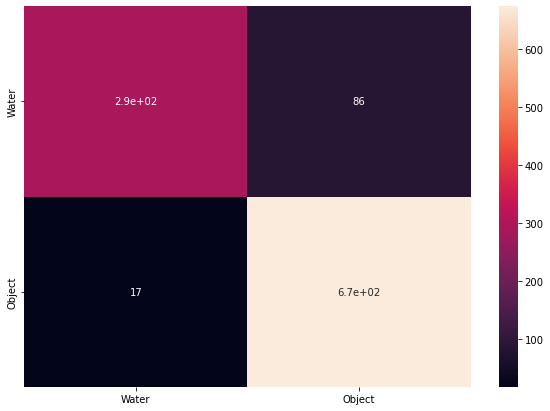

In [20]:
# confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
cm = confusion_matrix([np.argmax(a) for a in Y_test], [np.argmax(a) for a in Y_pred])

df_cm = pd.DataFrame(cm, index=["Water", "Object"], columns=["Water", "Object"])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)

In [31]:
def plot_windmills(left_top_coord, size=(1200, 800), intensity=1):
    (img_h, img_w) = size
    left_top_x, left_top_y = dataset_raw.index(left_top_coord[0], left_top_coord[1])
    needles = []
    step_size = 15

    for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
        for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
            cc = dataset_raw.transform * (yy, xx)
            lx, ly = dataset_land.index(cc[0], cc[1])
            if img_land[lx, ly] != 1:
                continue
            needles.append({'lon': cc[0], 'lat': cc[1]})

    test_images = np.stack([get_processed_image(coord) for coord in needles])
    results = model.predict(test_images)

    from matplotlib import pyplot as plt

    search_space = np.copy(img_raw[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
    search_space = search_space ** (1 / 4)
    highlight = np.max(search_space) * 0.75 * intensity

    found = 0
    coords = []
    for i, result in enumerate(results):
        if result[1] > result[0]:
            found += 1
            coord = needles[i]
            xx, yy = dataset_raw.index(coord['lon'], coord['lat'])
            xx -= left_top_x
            yy -= left_top_y

            search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
            search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
            search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            coords.append(coord)

    print("found {} windmills".format(found))

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(search_space)

    return coords

found 159 windmills


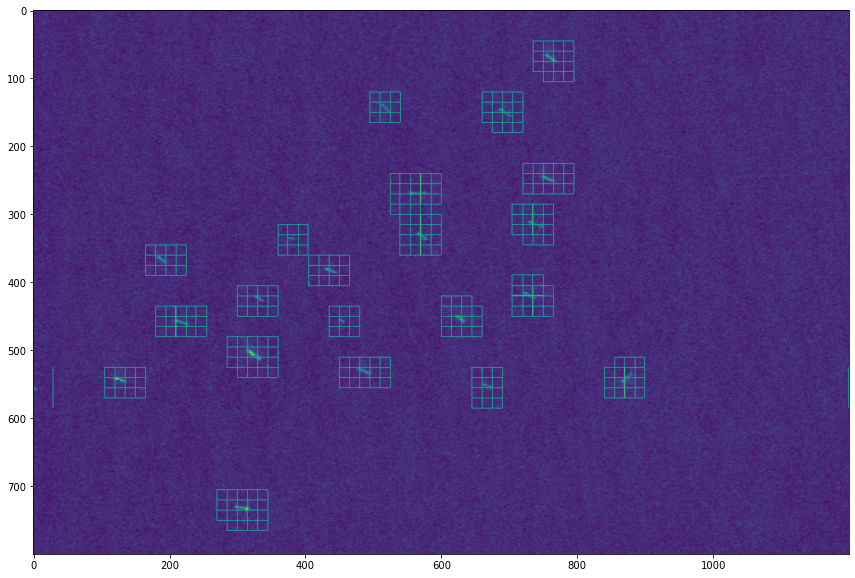

In [28]:
# vb boten
plot_windmills((2.56834,51.48205))

found 341 windmills


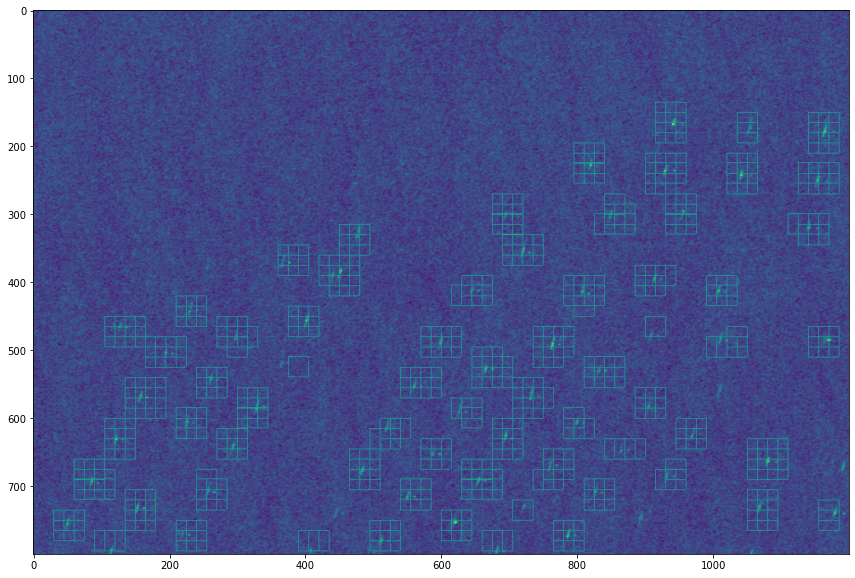

In [23]:
# vb molens
plot_windmills((1.85730,52.01960))

found 0 windmills


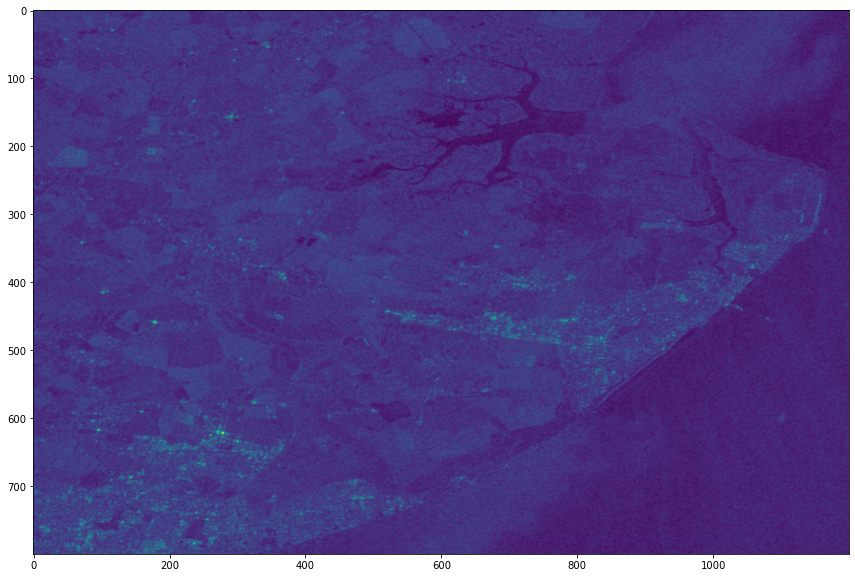

In [24]:
# vb kust
plot_windmills((1.12835,51.90720))

2021-12-14 22:28:51.128157: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 360072000 exceeds 10% of free system memory.


found 1574 windmills


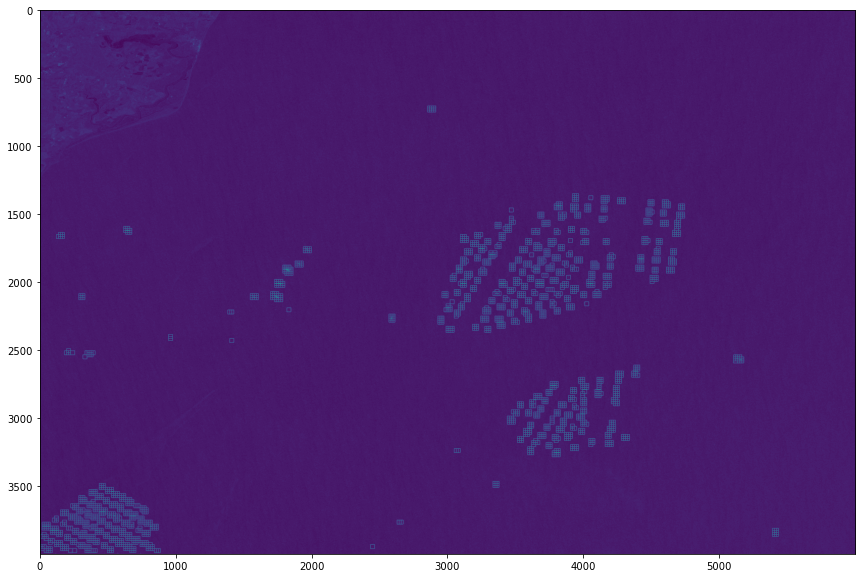

In [32]:
# het duurt redelijk lang voor dit te runnen
coords = plot_windmills((1.4378,52.1898), (1200 * 5, 800 * 5), intensity=2)

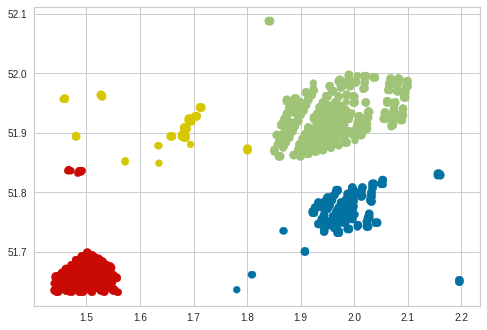

             X          Y  cluster
0     1.839561  52.088911        1
1     1.841665  52.088911        1
2     1.843768  52.088911        1
3     1.839561  52.086807        1
4     1.841665  52.086807        1
...        ...        ...      ...
1569  1.511395  51.632423        0
1570  1.532431  51.632423        0
1571  1.534535  51.632423        0
1572  1.557675  51.632423        0
1573  1.559779  51.632423        0

[1574 rows x 3 columns]


In [39]:
from sklearn import datasets, cluster, neighbors, metrics, tree, svm, mixture

colors = np.array(['r', 'g', 'b', 'y', 'c', 't'])

def apply(X, algo):
    algo.fit(X)
    labels = algo.labels_.astype(np.int)
    plt.scatter(X[:, 0], X[:, 1], color=colors[labels])
    plt.show()
    return labels

df = pd.DataFrame(coords)
X = df.to_numpy()

labels = apply(X, cluster.KMeans(n_clusters=4))

#apply(X, cluster.DBSCAN(eps=.011))
#apply(X, cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors"))

cluster_map = pd.DataFrame()
cluster_map['X'] = X[:, 0]
cluster_map['Y'] = X[:, 1]
cluster_map['cluster'] = labels

print(cluster_map)

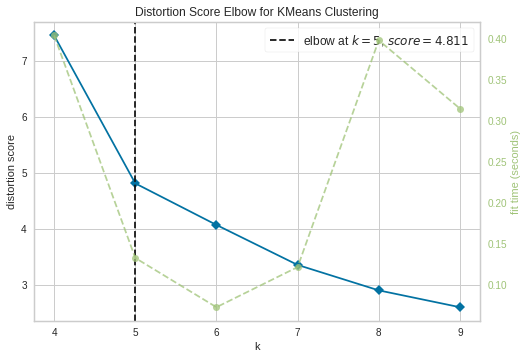

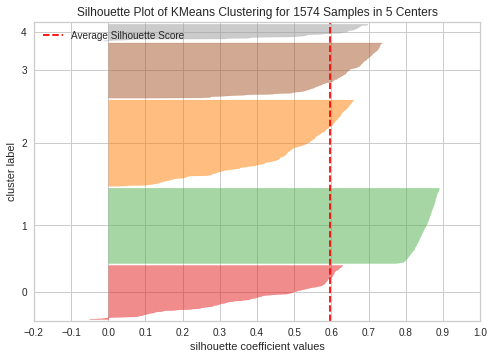

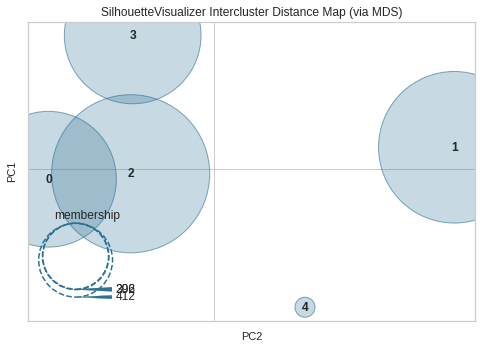

1574


In [37]:


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
# X, y = make_blobs(n_samples=1000, centers=5, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
model = SilhouetteVisualizer(KMeans(5))
model.fit(X)
model.show()

from yellowbrick.cluster import InterclusterDistance
visualizer = InterclusterDistance(model)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

print(len(X))

In [41]:
from shapely.geometry import Point, LineString
from functools import partial
from shapely.ops import transform
import pyproj
import geopandas as gpd
import pandas as pd

def bounding_box(x_coordinates, y_coordinates):
    # x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

list_lon = []
list_lat = []
list_geom = []
# for final_coord in final_results:
#     list_lon.append(final_coord[0])
#     list_lat.append(final_coord[1])

#print(min(final_results[0]))
#print(cluster_map[cluster_map.cluster == 2])
column_values = cluster_map["cluster"].values
clusters =  np.unique(column_values)
bboxs = []
for cluster in clusters:
    bboxs.append(bounding_box(cluster_map[cluster_map.cluster == cluster]['X'],cluster_map[cluster_map.cluster == cluster]['Y']))
print(bboxs)
l_lats = []
l_lons = []
boxes = []
for bbox in bboxs:
    print(bbox)

    l_lats.append(bbox[0][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[0][0])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[0][1])
    # print(l_lats)
    # print(l_lons)

    bb = gpd.points_from_xy(l_lats, l_lons, crs="EPSG:4326")
    print(l_lats)
    print(l_lons)
    print('--')
    print(bb)
    boxes.append(LineString(bb))
    l_lats = []
    l_lons = []

df_result = gpd.GeoDataFrame({
       # 'geometry': gpd.points_from_xy(list_lon, list_lat, crs="EPSG:4326").buffer(0.008)
        'geometry': boxes
})
print(df_result)


df_result['geometry']
from shapely.ops import unary_union
cu = unary_union(df_result['geometry']);
df2_result = gpd.GeoDataFrame({
        'geometry': cu
})


# final_results
#
# df_result = gpd.GeoDataFrame({
#                 'lon': pd.Series(list_lon, dtype='float'),
#                 'lat': pd.Series(list_lat, dtype='float'),
#                 'geometry': pd.Series(list_geom, dtype='geometry')})
df2_result.crs = 'epsg:4326'
df2_result.to_file("result.shp")

[[(1.4398717374311645, 51.63242343820533), (1.5597785466755694, 51.83857900497641)], [(1.8395611015791806, 51.85961528729999), (2.10041100239157, 52.08891076462701)], [(1.7806595110731573, 51.636630694670046), (2.1971779010800367, 51.83226812027934)], [(1.4567007632900284, 51.8490971461382), (1.801695793396737, 51.96479669891789)]]
[(1.4398717374311645, 51.63242343820533), (1.5597785466755694, 51.83857900497641)]
[1.4398717374311645, 1.5597785466755694, 1.5597785466755694, 1.4398717374311645, 1.4398717374311645]
[51.63242343820533, 51.63242343820533, 51.83857900497641, 51.83857900497641, 51.63242343820533]
--
<GeometryArray>
Length: 5, dtype: geometry
[(1.8395611015791806, 51.85961528729999), (2.10041100239157, 52.08891076462701)]
[1.8395611015791806, 2.10041100239157, 2.10041100239157, 1.8395611015791806, 1.8395611015791806]
[51.85961528729999, 51.85961528729999, 52.08891076462701, 52.08891076462701, 51.85961528729999]
--
<GeometryArray>
Length: 5, dtype: geometry
[(1.7806595110731573